## What has our model learnt?

Measuring accuracy is not enough!

Does the model make decisions based on reasonable evidence?

In [1]:
import random as rn
rn.seed(1254)

import numpy as np
np.random.seed(1515)

import h5py
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

import tensorflow as tf
tf.set_random_seed(2)

# block multithreading for the sake of reproducible results
config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 
)

# dynamically grow the memory used on the GPU 
config.gpu_options.allow_growth = True  
sess = tf.Session(graph= tf.get_default_graph(), config=config) 
    
import keras 
from keras import backend as K
from keras.models import load_model
K.set_learning_phase(1)

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
workspace = '/vol/vssp/AcousticEventsDetection/DLGdansk/UrbanSound/'
modelpath = os.path.join(workspace,'models','crnn_epoch_156_val_loss_1.3890.hdf5')
hdf5_path = os.path.join(workspace,'dataset.hdf5')

In [4]:
# LOAD DATA
hf = h5py.File(hdf5_path, 'r')
X_train = np.array(hf.get('X_train') )
y_train = np.array(hf.get('y_train'))
X_val =  np.array(hf.get('X_val'))
y_val= np.array(hf.get('y_val'))
X_test = np.array(hf.get('X_test'))
y_test = np.array(hf.get('y_test'))

n_features= hf.get('n_features').value
n_frames=hf.get('max_length_samp').value
label_list= hf.get('label_list').value

In [5]:
model=load_model(modelpath)

In [6]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict.keys()

[u'conv2d_4',
 u'reshape_1',
 u'max_pooling2d_4',
 u'max_pooling2d_1',
 u'dense_1',
 u'max_pooling2d_3',
 u'max_pooling2d_2',
 u'lstm_1',
 u'batch_normalization_4',
 u'input_1',
 u'batch_normalization_2',
 u'batch_normalization_3',
 u'batch_normalization_1',
 u'conv2d_1',
 u'conv2d_3',
 u'conv2d_2']

[u'conv2d_4',
 u'reshape_1',
 u'max_pooling2d_4',
 u'max_pooling2d_1',
 u'dense_1',
 u'max_pooling2d_3',
 u'max_pooling2d_2',
 u'lstm_1',
 u'batch_normalization_4',
 u'input_1',
 u'batch_normalization_2',
 u'batch_normalization_3',
 u'batch_normalization_1',
 u'conv2d_1',
 u'conv2d_3',
 u'conv2d_2']

#### What did the filters learn? 

+ Which input activates the filters the most?

In [7]:
# choose the layer to visualise
layer_name = 'conv2d_1'

# get the dimensions of the input
input_data = model.input

In [8]:
# choose which filters to visualise
filter_index = range(10,30)

gen_im_conv2d_1=[]

# define the output to be maximalised
layer_output = layer_dict[layer_name].output

for f in filter_index:
    # define a cost function to maximise 
    cost = K.mean(layer_output[:, :, :, f],)
    
    grads = 0
    # compute the gradient of the input picture wrt this cost
    grads = K.gradients(cost, input_data)[0]

    # normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the cost and grads given the input matrix
    iterate = K.function([input_data], [cost, grads])
    
    input_data_gen = np.random.random((1, n_frames, n_features, 1))
    for i in range(10):
        loss_value, grads_value = iterate([input_data_gen])
        input_data_gen += grads_value 
        
        if loss_value <= 0.:
           # some filters get stuck to 0, we can skip them
            break
    gen_im_conv2d_1.append(input_data_gen)

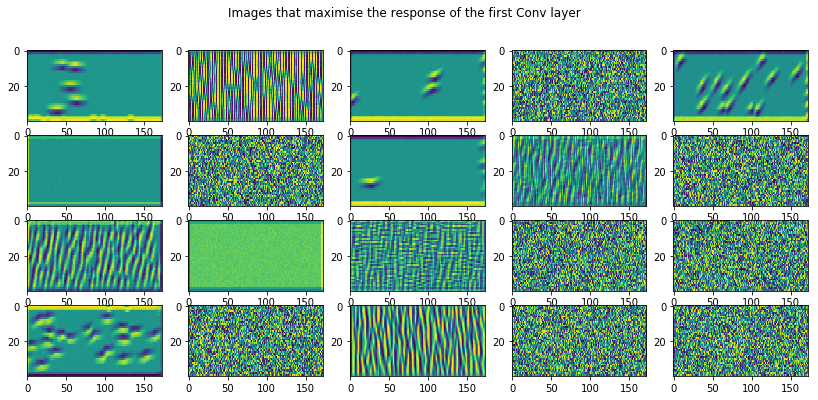

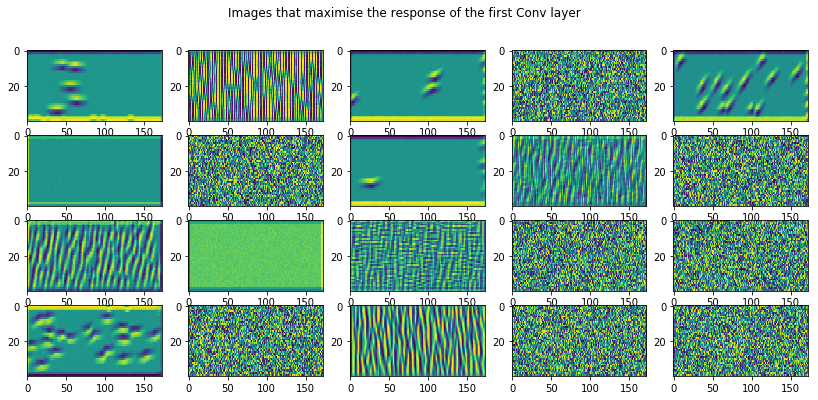

In [9]:
fig = plt.figure()
plt.suptitle('Images that maximise the response of the first Conv layer')
for idx, im in enumerate(gen_im_conv2d_1): 
    plt.subplot(4,5,idx+1)
    plt.imshow(im[0,:,:,0].T, aspect='auto')

In [10]:
# choose the layer to visualise
layer_name = 'conv2d_2'

In [11]:
# choose which filters to visualise
filter_index = range(10,30)

gen_im_conv2d_2=[]

# define the output to be maximalised
layer_output = layer_dict[layer_name].output

for f in filter_index:
    # define a cost function to maximise 
    cost = K.mean(layer_output[:, :, :, f],)
    
    grads = 0
    # compute the gradient of the input picture wrt this cost
    grads = K.gradients(cost, input_data)[0]

    # normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the cost and grads given the input matrix
    iterate = K.function([input_data], [cost, grads])
    
    input_data_gen = np.random.random((1, n_frames, n_features, 1))
    for i in range(10):
        loss_value, grads_value = iterate([input_data_gen])
        input_data_gen += grads_value 
        
        if loss_value <= 0.:
           # some filters get stuck to 0, we can skip them
            break
    gen_im_conv2d_2.append(input_data_gen)

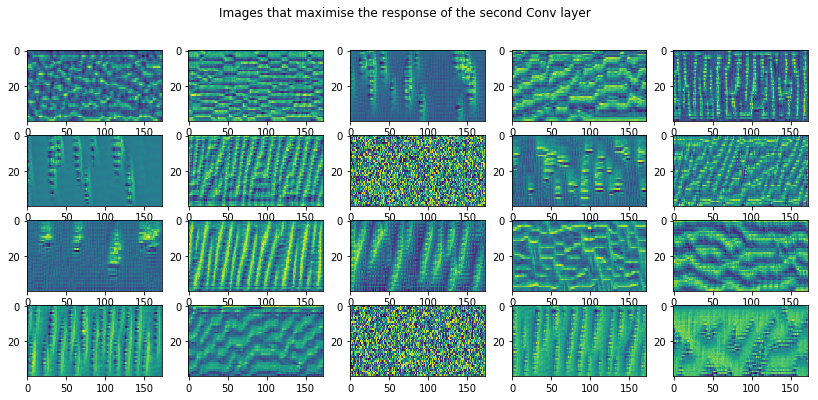

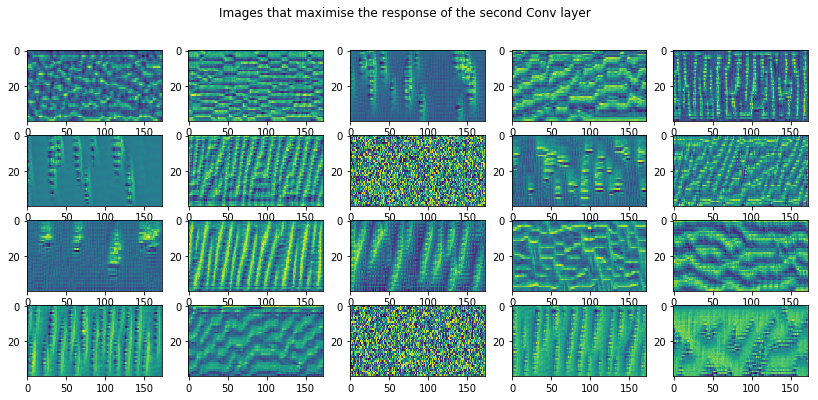

In [12]:
fig = plt.figure()
plt.suptitle('Images that maximise the response of the second Conv layer')
for idx, im in enumerate(gen_im_conv2d_2):
    plt.subplot(4,5,idx+1)
    plt.imshow(im[0,:,:,0].T, aspect='auto')

In [13]:
# choose the layer to visualise
layer_name = 'conv2d_3'

In [14]:
# choose which filters to visualise
filter_index = range(10,30)

gen_im_conv2d_3=[]

# define the output to be maximalised
layer_output = layer_dict[layer_name].output

for f in filter_index:
    # define a cost function to maximise 
    cost = K.mean(layer_output[:, :, :, f],)
    
    grads = 0
    # compute the gradient of the input picture wrt this cost
    grads = K.gradients(cost, input_data)[0]

    # normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the cost and grads given the input matrix
    iterate = K.function([input_data], [cost, grads])
    
    input_data_gen = np.random.random((1, n_frames, n_features, 1))
    for i in range(10):
        loss_value, grads_value = iterate([input_data_gen])
        input_data_gen += grads_value 
        
        if loss_value <= 0.:
           # some filters get stuck to 0, we can skip them
            break
    gen_im_conv2d_3.append(input_data_gen)

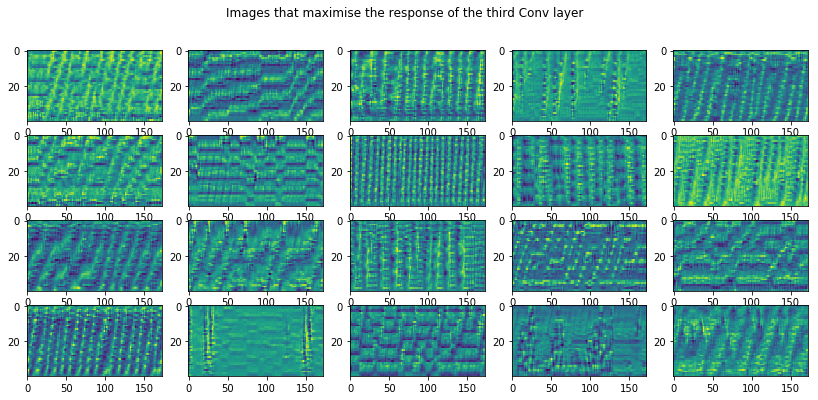

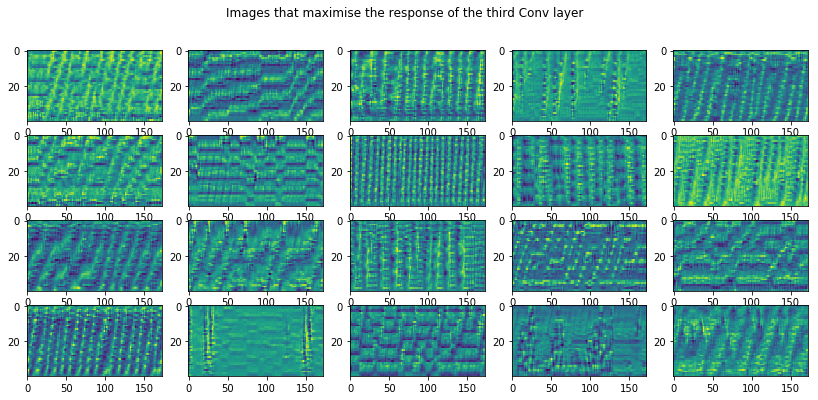

In [15]:
fig = plt.figure()
plt.suptitle('Images that maximise the response of the third Conv layer')
for idx, im in enumerate(gen_im_conv2d_3):    
    plt.subplot(4,5,idx+1)
    plt.imshow(im[0,:,:,0].T, aspect='auto')


#### How do the filters look like?

+ Let's plot the filters itself

(5, 5, 48, 48)
(5, 5, 48, 48)


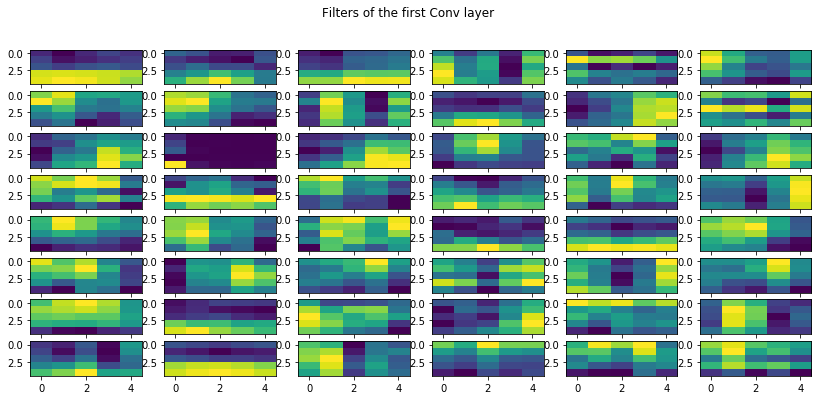

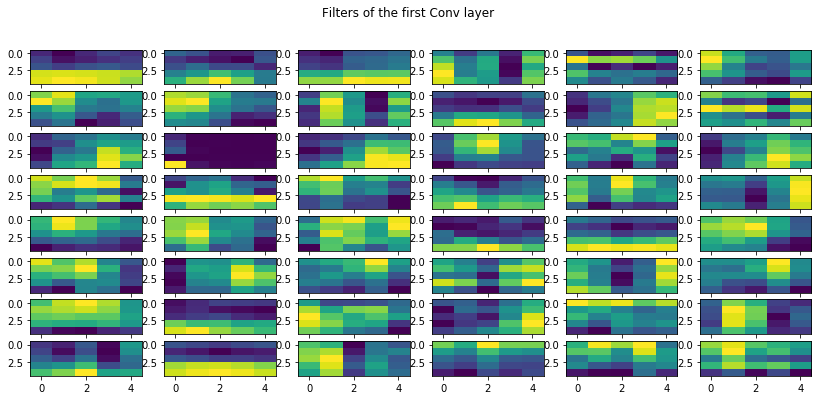

In [35]:
print(model.get_weights()[0].shape)

#choose the first Conv layer
filters=model.get_weights()[0]
fig=plt.figure()
plt.suptitle("Filters of the first Conv layer")
for idx in range(0,filters.shape[3]):
    plt.subplot(8,6,idx+1)
    im = plt.imshow(filters[:,:,0,idx], aspect='auto')

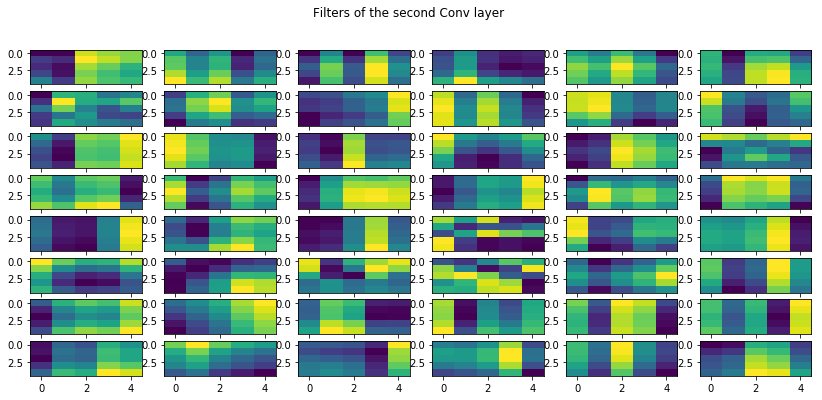

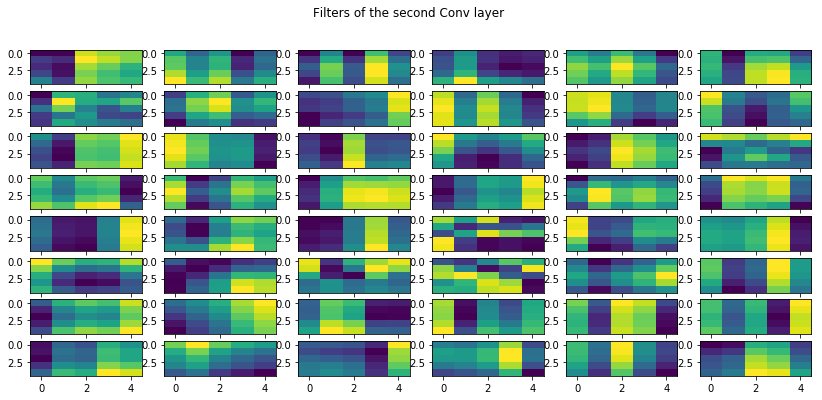

In [34]:
#choose the first Conv layer
filters=model.get_weights()[6]
fig=plt.figure()
plt.suptitle("Filters of the second Conv layer")
for idx in range(0,filters.shape[3]):
    plt.subplot(8,6,idx+1)
    im = plt.imshow(filters[:,:,0,idx], aspect='auto')

(5, 5, 48, 48)
(5, 5, 48, 48)


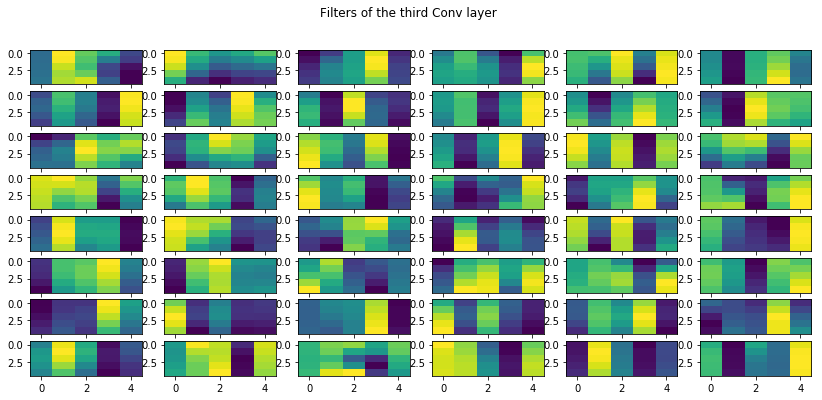

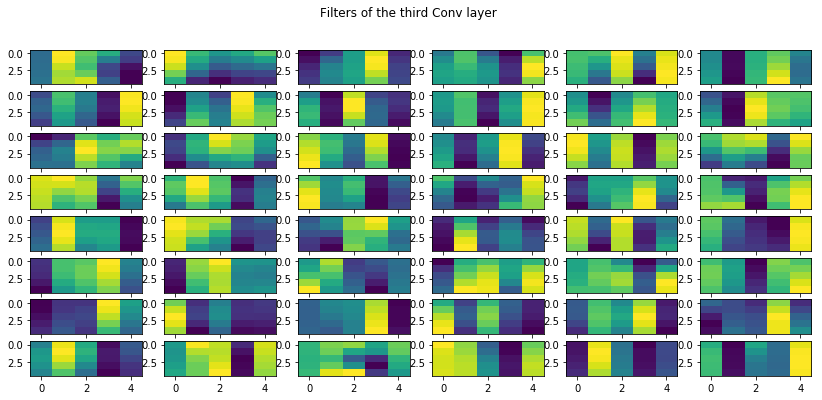

In [40]:
print(model.get_weights()[12].shape)

#choose the first Conv layer
filters=model.get_weights()[12]
fig=plt.figure()
plt.suptitle("Filters of the third Conv layer")
for idx in range(0,filters.shape[3]):
    plt.subplot(8,6,idx+1)
    im = plt.imshow(filters[:,:,0,idx], aspect='auto')

#### How does a perfect siren look like according to our model?

+ Let's maximise the output of each class 

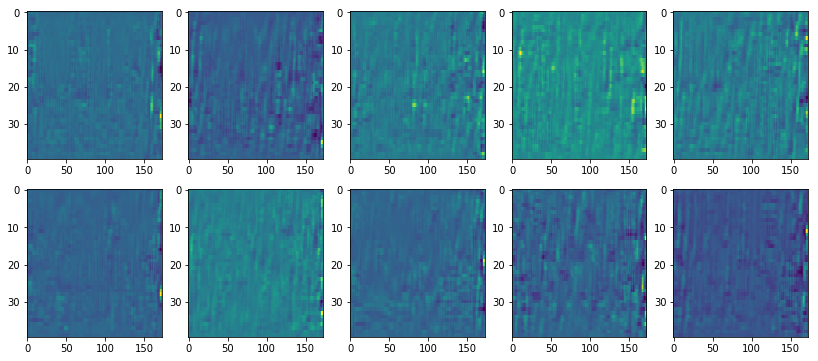

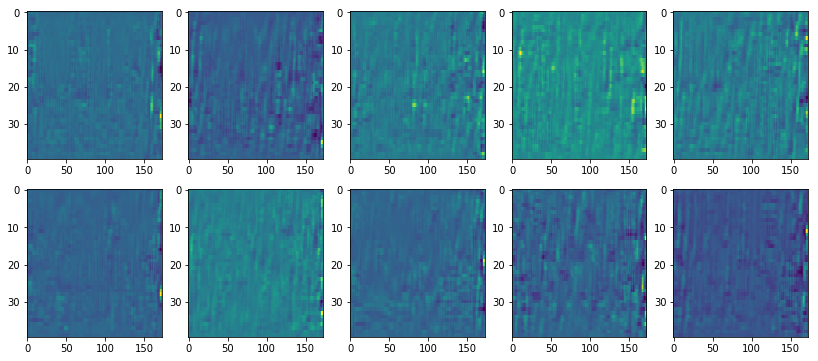

In [69]:
max_output=[]

for out in range(0,10):
    # define a cost function to maximise 
    cost = K.mean(model.output[:,out])
    
    grads = 0
    # compute the gradient of the input picture wrt this cost
    grads = K.gradients(cost, input_data)[0]

    # normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # this function returns the cost and grads given the input picture
    iterate = K.function([input_data], [cost, grads])
    
    input_data_gen = np.random.random((1, n_frames, n_features, 1))
    for i in range(50):
        loss_value, grads_value = iterate([input_data_gen])
        input_data_gen += grads_value 
        if loss_value <= 0:
           # some filters get stuck to 0, we can skip them
            break
    max_output.append(input_data_gen)

fig = plt.figure()
for idx, im in enumerate(max_output):
    plt.subplot(2,5,idx+1)
    plt.imshow(im[0,:,:,0].T, aspect='auto')

In [18]:
prediction = model.predict(np.squeeze(np.array(max_output),axis=1), batch_size=10, verbose=1)
print(prediction)
print(prediction.argmax(axis=0))

10/10 [==============================] - 1s 78ms/step
[[  7.09205046e-02   9.83916034e-05   1.22019854e-04   6.69072103e-03
    5.14865815e-06   3.39936487e-05   3.83084152e-05   3.53682503e-06
    5.27090560e-06   1.53829688e-02]
 [  8.02638358e-04   7.38950551e-01   2.93631908e-02   8.52907836e-01
    7.18502747e-03   4.35208064e-03   1.65106531e-03   1.72893051e-04
    1.19344899e-02   1.11286854e-02]
 [  1.69576979e-05   6.23069500e-05   9.25692022e-01   3.31681542e-04
    5.24452589e-05   2.20682887e-05   6.90817501e-07   6.35777906e-06
    5.75230370e-05   6.90916227e-03]
 [  7.36170250e-06   1.57751070e-04   3.03152343e-03   3.71708125e-01
    3.75190866e-05   1.88509530e-05   1.41957080e-05   8.62230081e-06
    1.30941247e-04   2.79024313e-03]
 [  3.03950132e-04   7.41847471e-05   4.25234233e-04   7.32403132e-04
    9.97425735e-01   9.69120738e-05   3.53022688e-03   2.97093298e-04
    3.55450995e-03   2.59829964e-03]
 [  1.88081397e-03   1.25505272e-02   1.60228610e-02   1.1805

In [ ]:
loss = K.mean(model.output[:, 2])

grads = 0
# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_data)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_data], [loss, grads])

input_spec = X_test[2].T
input_data_gen = np.expand_dims(input_spec, 0)
input_data_gen = np.expand_dims(input_data_gen, 3)
for i in range(50):
    loss_value, grads_value = iterate([input_data_gen])
    input_data_gen_tmp = input_data_gen +grads_value
    input_data_gen = input_data_gen_tmp
    print('Current loss value:', loss_value)
    if loss_value <= 0:
       # some filters get stuck to 0, we can skip them
        break
        
f=plt.figure()
plt.subplot(2,1,1)
plt.imshow(input_spec.T, aspect='auto')
plt.colorbar()
plt.subplot(2,1,2)
plt.imshow(input_data_gen[0,:,:,0].T, aspect='auto')
plt.colorbar()

In [71]:
np.max(input_spec - np.squeeze(input_data_gen))

27.583256233483553

27.583256233483553

In [59]:
predictionASCENT = model.predict(input_data_gen, batch_size=1, verbose=1)
print(predictionASCENT)
print(np.argmax(predictionASCENT))
prediction = model.predict(np.expand_dims(np.expand_dims(X_test[2].T,0),3), batch_size=1, verbose=1)
print(prediction)
print(y_test[2])
print(np.argmax(prediction))

1/1 [==============================] - 0s 42ms/step
[[  3.22496126e-05   2.04351236e-05   8.05738032e-01   1.35038281e-02
    2.33165538e-05   3.40704219e-06   1.19213491e-05   4.22497624e-06
    3.08664545e-04   1.57393911e-03]]
2
1/1 [==============================] - 0s 43ms/step
[[  3.22496126e-05   2.04351236e-05   8.05738032e-01   1.35038281e-02
    2.33165538e-05   3.40704219e-06   1.19213491e-05   4.22497624e-06
    3.08664545e-04   1.57393911e-03]]
2
1/1 [==============================] - 0s 43ms/step
[[  3.22496126e-05   2.04351236e-05   8.05738032e-01   1.35038281e-02
    2.33165538e-05   3.40704219e-06   1.19213491e-05   4.22497624e-06
    3.08664545e-04   1.57393911e-03]]
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
2
[[  3.22496126e-05   2.04351236e-05   8.05738032e-01   1.35038281e-02
    2.33165538e-05   3.40704219e-06   1.19213491e-05   4.22497624e-06
    3.08664545e-04   1.57393911e-03]]
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
2


In [48]:
print(y_test[2])

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
